Notebook này chạy trên local.

# Store Sales - Time Series Forecasting

[Link_to_competition](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)

## Exploring datasets and feature engineering

In [1]:
import os

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = '.'

In [3]:
!kaggle competitions download -c store-sales-time-series-forecasting

store-sales-time-series-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
from zipfile import ZipFile
with ZipFile('store-sales-time-series-forecasting.zip') as f:
    f.extractall('data')

In [5]:
import pandas as pd

In [6]:
raw_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
holidays_df = pd.read_csv('data/holidays_events.csv')
oil_df = pd.read_csv('data/oil.csv')
stores_df = pd.read_csv('data/stores.csv')
transactions_df = pd.read_csv('data/transactions.csv')
sub_df = pd.read_csv('data/sample_submission.csv')

In [7]:
def view_avg_of_each(cat_features: str):
    d = dict()
    cols = raw_df[cat_features].unique()
    for x in cols:
        d[x] = raw_df[raw_df[cat_features]==x]['sales'].mean()
    return pd.Series(d, index=cols)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
def draw_numeric_features(data, x=None, y=None, overlap=None):
    plt.figure(figsize=(30,10))
    plt.grid()
    sns.lineplot(data, x=x, y=y)
    if overlap is not None:
        for plot in overlap:
            sns.lineplot(data=plot[0], x=plot[1], y=plot[2])

### `raw_df`

In [10]:
raw_df.drop(columns='id', inplace=True)

In [11]:
def get_info_of_date(df: pd.DataFrame):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.day_of_week

In [12]:
get_info_of_date(raw_df)

In [13]:
get_info_of_date(test_df)

In [14]:
view_avg_of_each('year')

2013    216.479530
2014    322.939786
2015    371.357193
2016    443.790297
2017    480.124466
dtype: float64

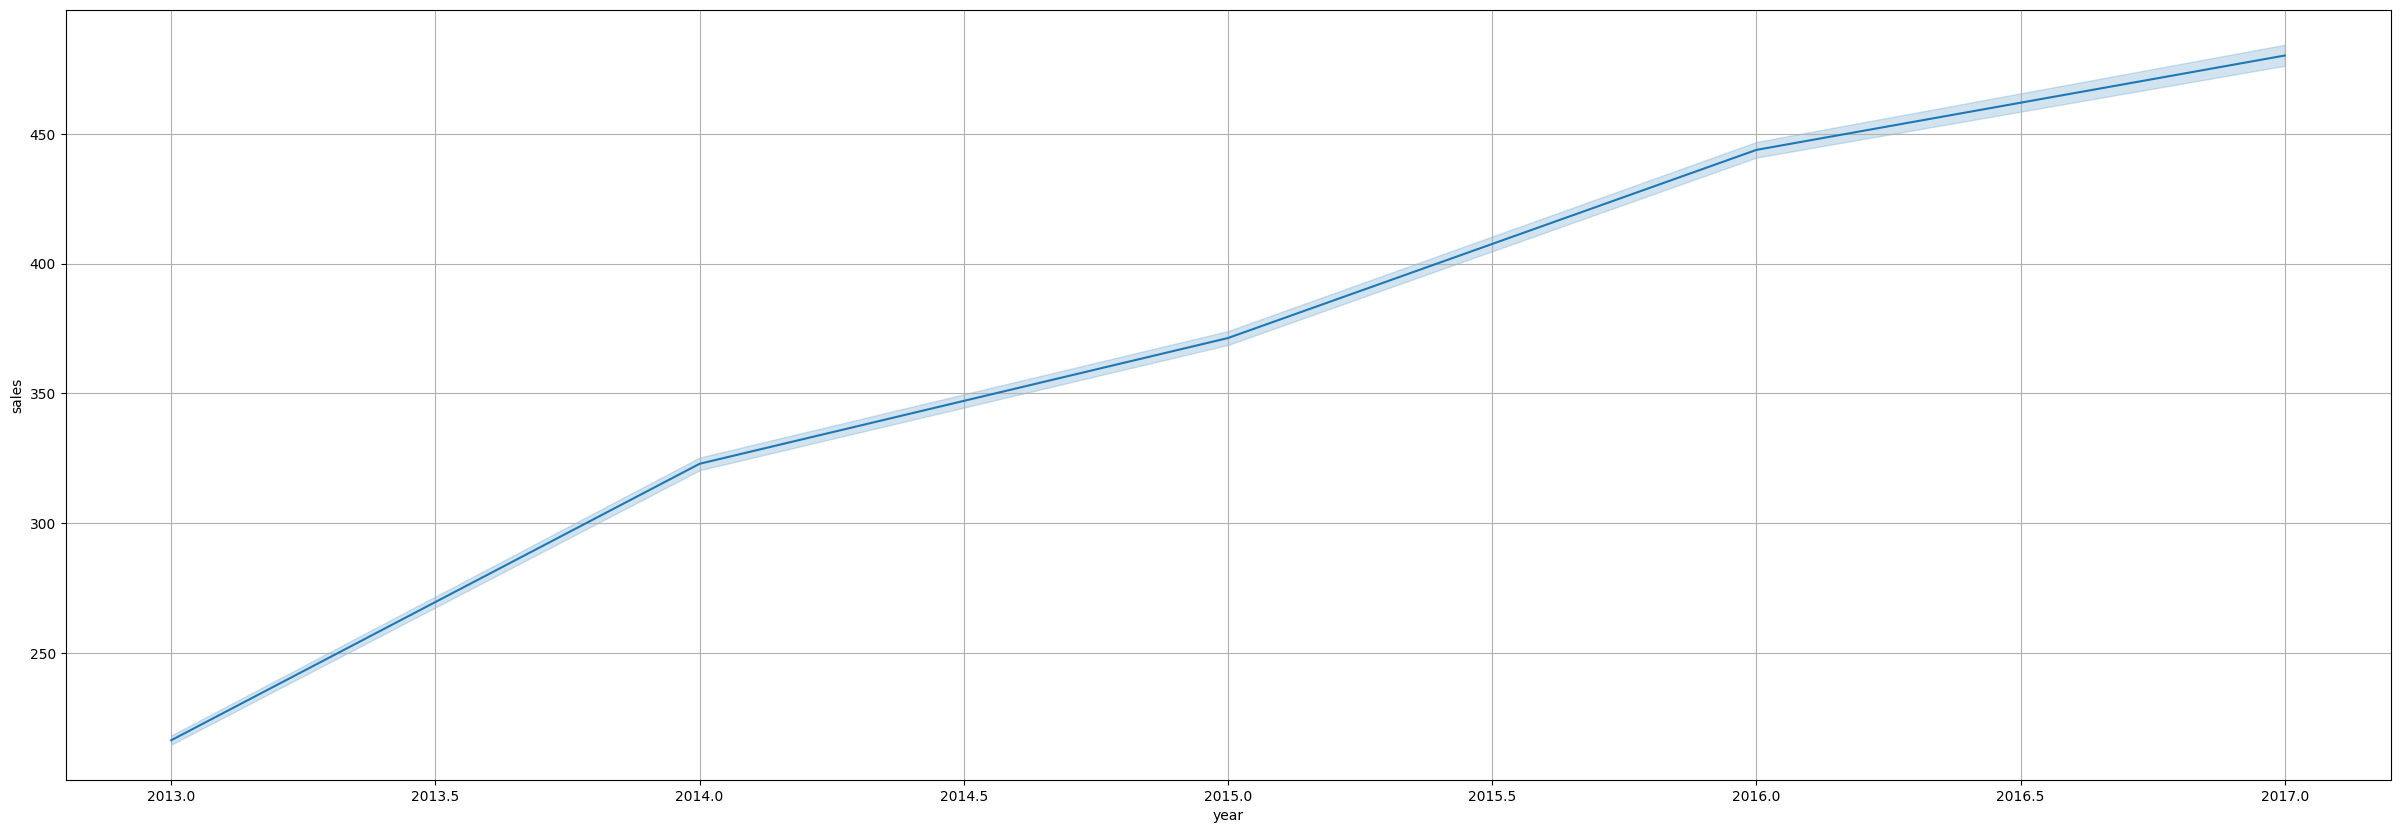

In [15]:
draw_numeric_features(raw_df, x='year', y='sales')

In [16]:
view_avg_of_each('month')

1     341.921554
2     320.928869
3     352.009294
4     339.199841
5     341.765820
6     353.597842
7     374.219111
8     336.992535
9     362.297418
10    362.407132
11    375.681762
12    453.740370
dtype: float64

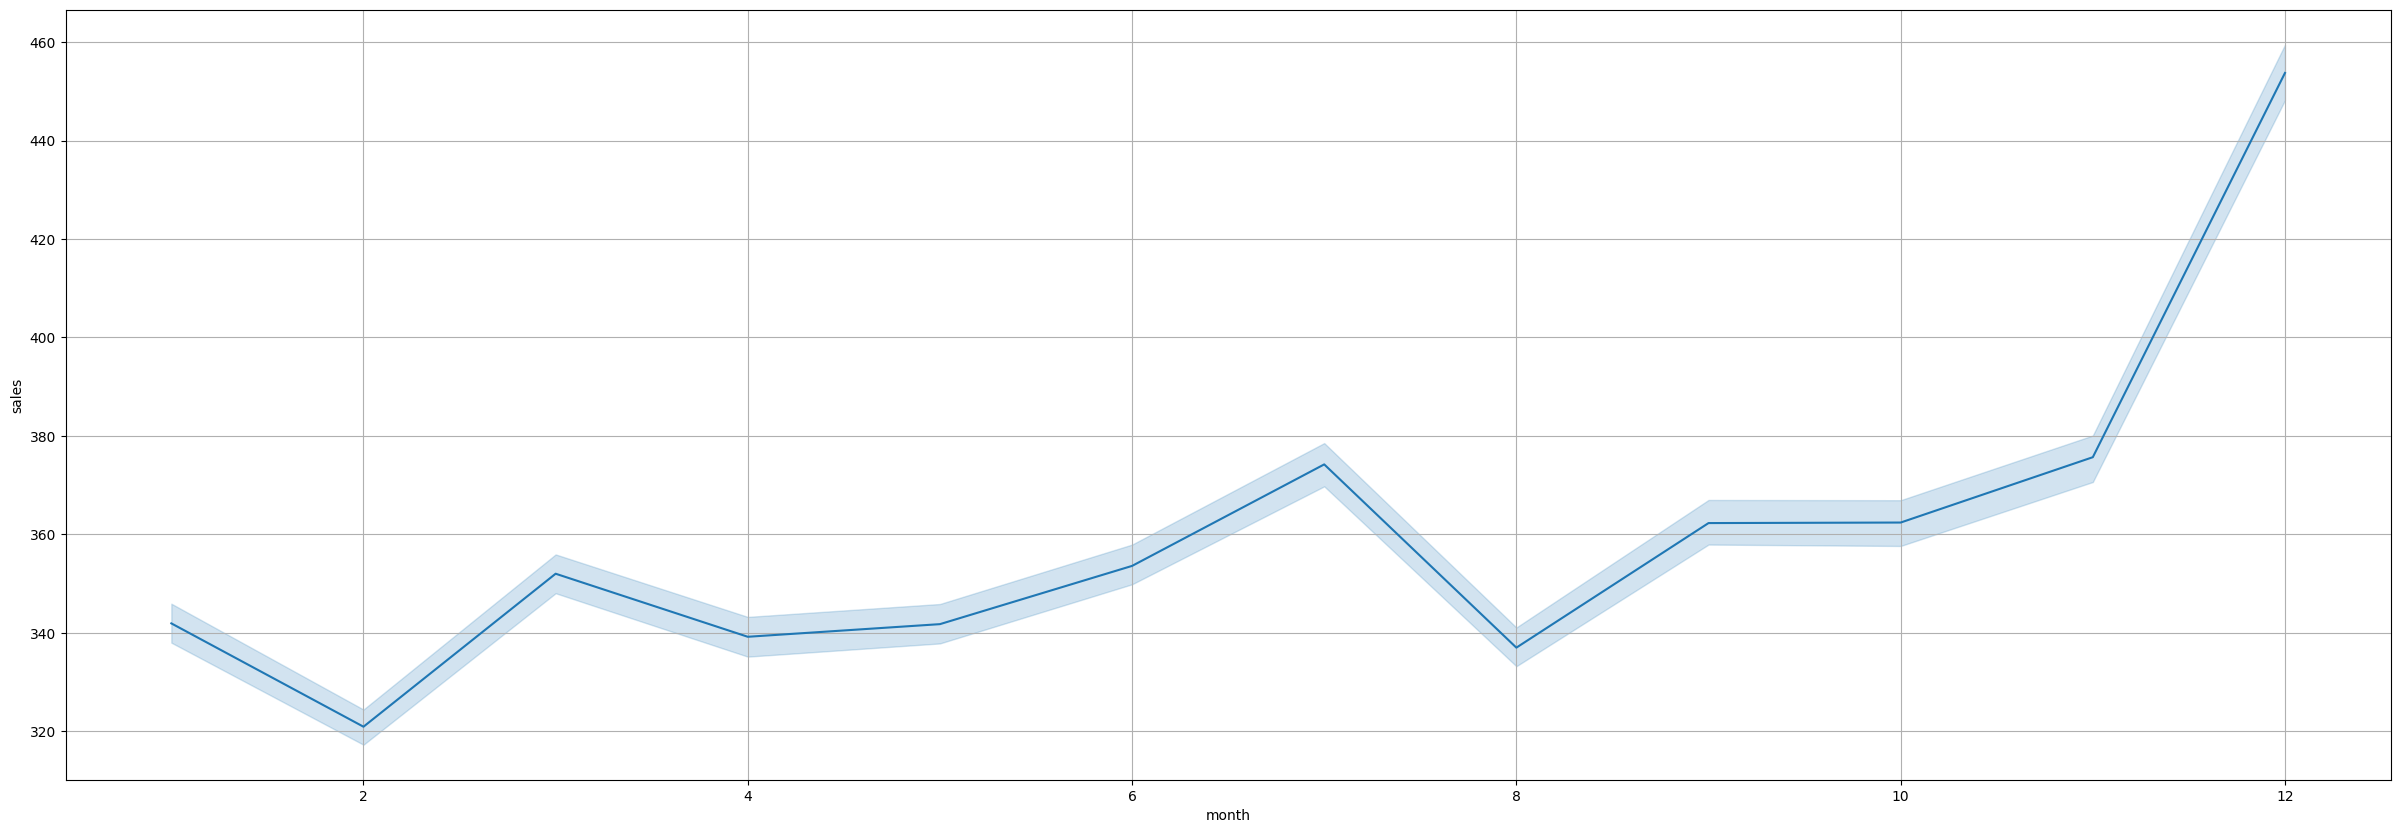

In [17]:
draw_numeric_features(raw_df, x='month', y='sales')

In [18]:
view_avg_of_each('day_of_week')

1    319.823843
2    332.909401
3    283.540517
4    325.238138
5    433.336472
6    463.085366
0    346.544732
dtype: float64

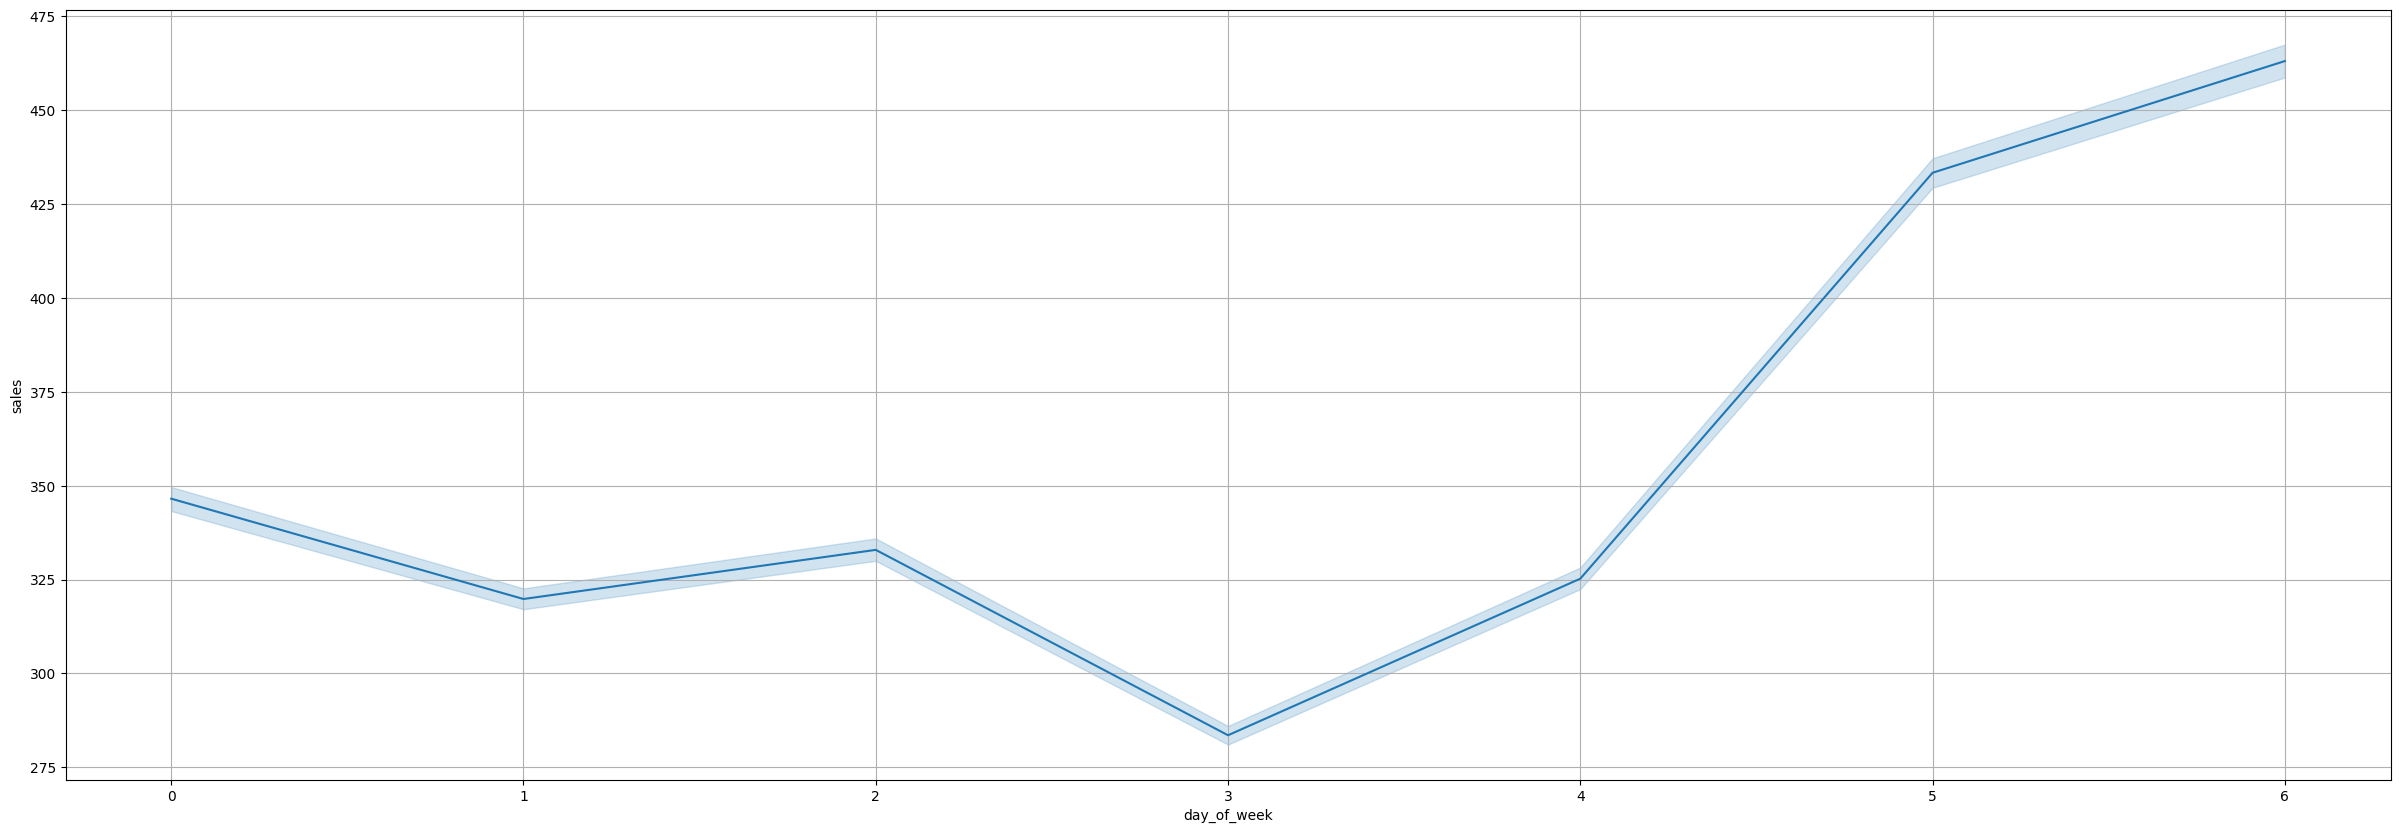

In [19]:
draw_numeric_features(raw_df, x='day_of_week', y='sales')

In [20]:
raw_df['is_weekend'] = raw_df['day_of_week'].apply(lambda x: 1 if x in [5,6] else 0)
test_df['is_weekend'] = test_df['day_of_week'].apply(lambda x: 1 if x in [5,6] else 0)

In [21]:
view_avg_of_each('is_weekend')

0    321.629081
1    448.179995
dtype: float64

### `oil_df`

In [22]:
get_info_of_date(oil_df)

In [23]:
training_date_min = pd.to_datetime('2016-08-01')

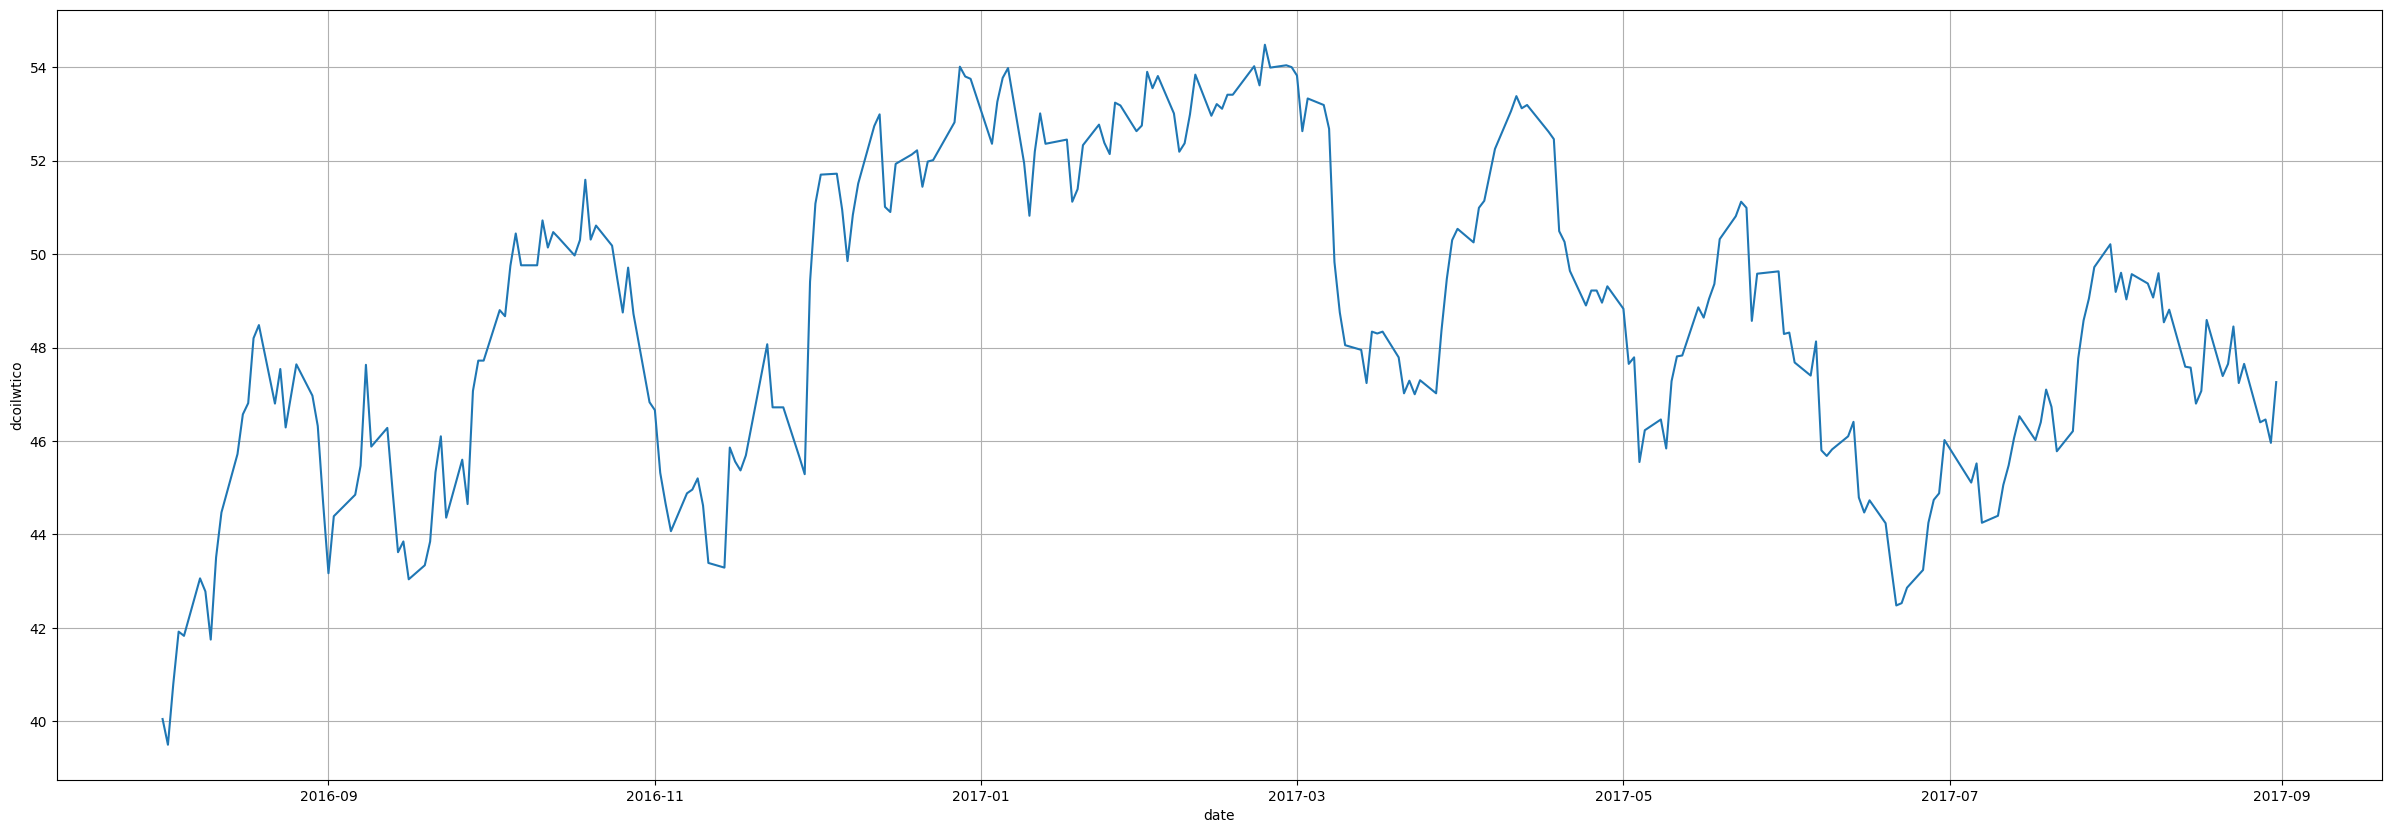

In [24]:
draw_numeric_features(oil_df[oil_df['date']>=training_date_min], x='date', y='dcoilwtico')

In [25]:
all_sales_df = raw_df.groupby(['date'])['sales'].mean().to_frame()
all_sales_df = all_sales_df[all_sales_df.index>=training_date_min]
all_sales_df

,sales
date,
2016-08-01,502.570373
2016-08-02,436.359618
2016-08-03,437.623350
2016-08-04,349.541581
2016-08-05,395.113771
...,...
2017-08-11,463.733851
2017-08-12,444.798280
2017-08-13,485.768618


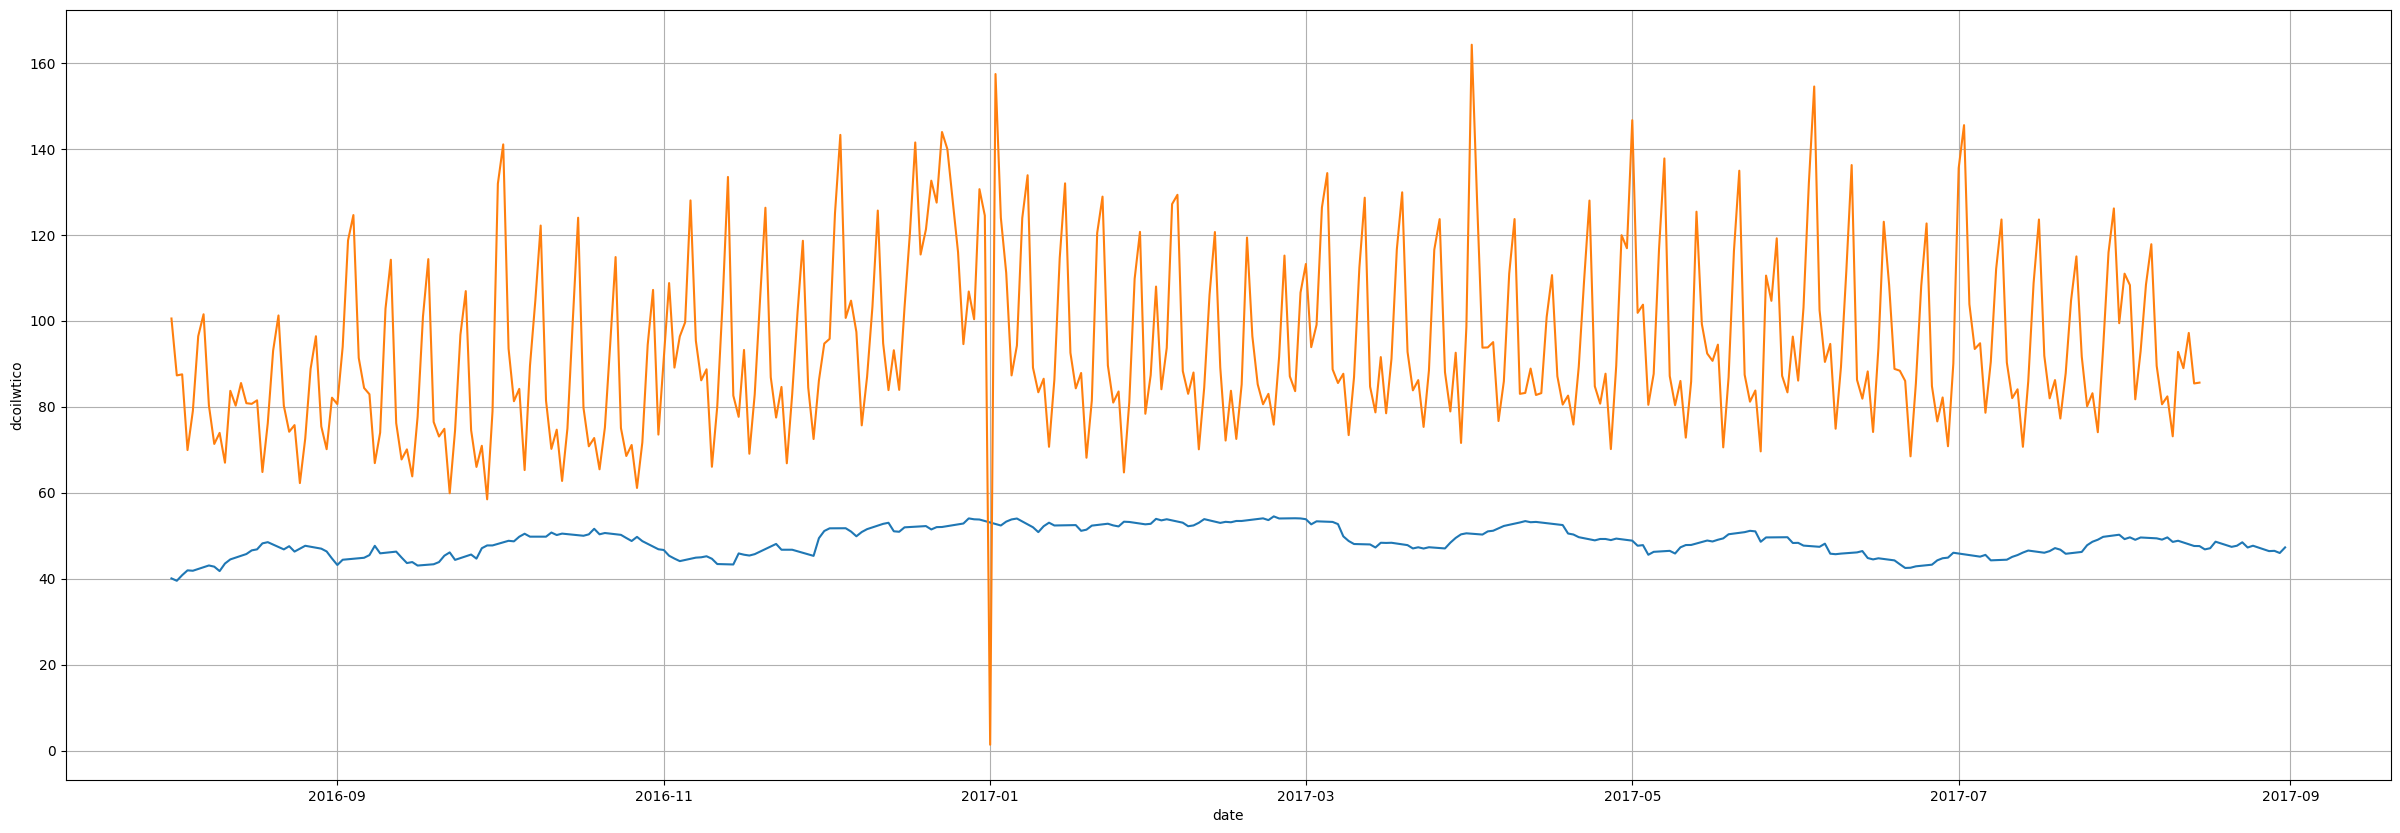

In [26]:
draw_numeric_features(oil_df[oil_df['date']>=training_date_min], x='date', y='dcoilwtico',
                      overlap=[[all_sales_df.apply(lambda x: x/5),'date','sales']])

In [27]:
oil_df['month_from'] = oil_df['year'].apply(lambda x: x-2013)*12 + oil_df['month']

In [28]:
oil_months = oil_df.groupby('month_from')['dcoilwtico'].mean()

In [29]:
oil_df.fillna({'dcoilwtico': -1.0}, inplace=True)

In [30]:
oil_df['dcoilwtico'] = oil_df.apply(lambda x: oil_months.get(x['month_from']) if x['dcoilwtico']<0 else x['dcoilwtico'], axis=1)

In [31]:
oil_df.drop(columns=['year','month','day','day_of_week','month_from'], inplace=True)

In [32]:
oil_df

,date,dcoilwtico
0,2013-01-01,94.756667
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-07,93.200000
...,...,...
1213,2017-08-25,47.650000
1214,2017-08-28,46.400000
1215,2017-08-29,46.460000
1216,2017-08-30,45.960000


In [33]:
raw_df = pd.merge(left=raw_df, right=oil_df, on='date', how='left')

In [34]:
raw_df['month_from'] = raw_df['year'].apply(lambda x: x-2013)*12 + raw_df['month']

In [35]:
raw_df.fillna({'dcoilwtico': -1.0}, inplace=True)

In [36]:
raw_df['dcoilwtico'] = raw_df.apply(lambda x: oil_months.get(x['month_from']) if x['dcoilwtico']<0 else x['dcoilwtico'], axis=1)

In [37]:
test_df = pd.merge(left=test_df, right=oil_df, on='date', how='left')
test_df['month_from'] = test_df['year'].apply(lambda x: x-2013)*12 + test_df['month']
test_df.fillna({'dcoilwtico': -1.0}, inplace=True)
test_df['dcoilwtico'] = test_df.apply(lambda x: oil_months.get(x['month_from']) if x['dcoilwtico']<0 else x['dcoilwtico'], axis=1)

In [38]:
raw_df['sales'].corr(raw_df['dcoilwtico'])

-0.07485568645415375

### stores_df

In [39]:
stores_df.head(10)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [40]:
raw_df = pd.merge(left=raw_df, right=stores_df, on='store_nbr', how='left')
test_df = pd.merge(left=test_df, right=stores_df, on='store_nbr', how='left')

In [41]:
view_avg_of_each('city').head(5)

Quito        556.577090
Cayambe      509.709179
Latacunga    190.583961
Riobamba     204.921881
Ibarra       206.061866
dtype: float64

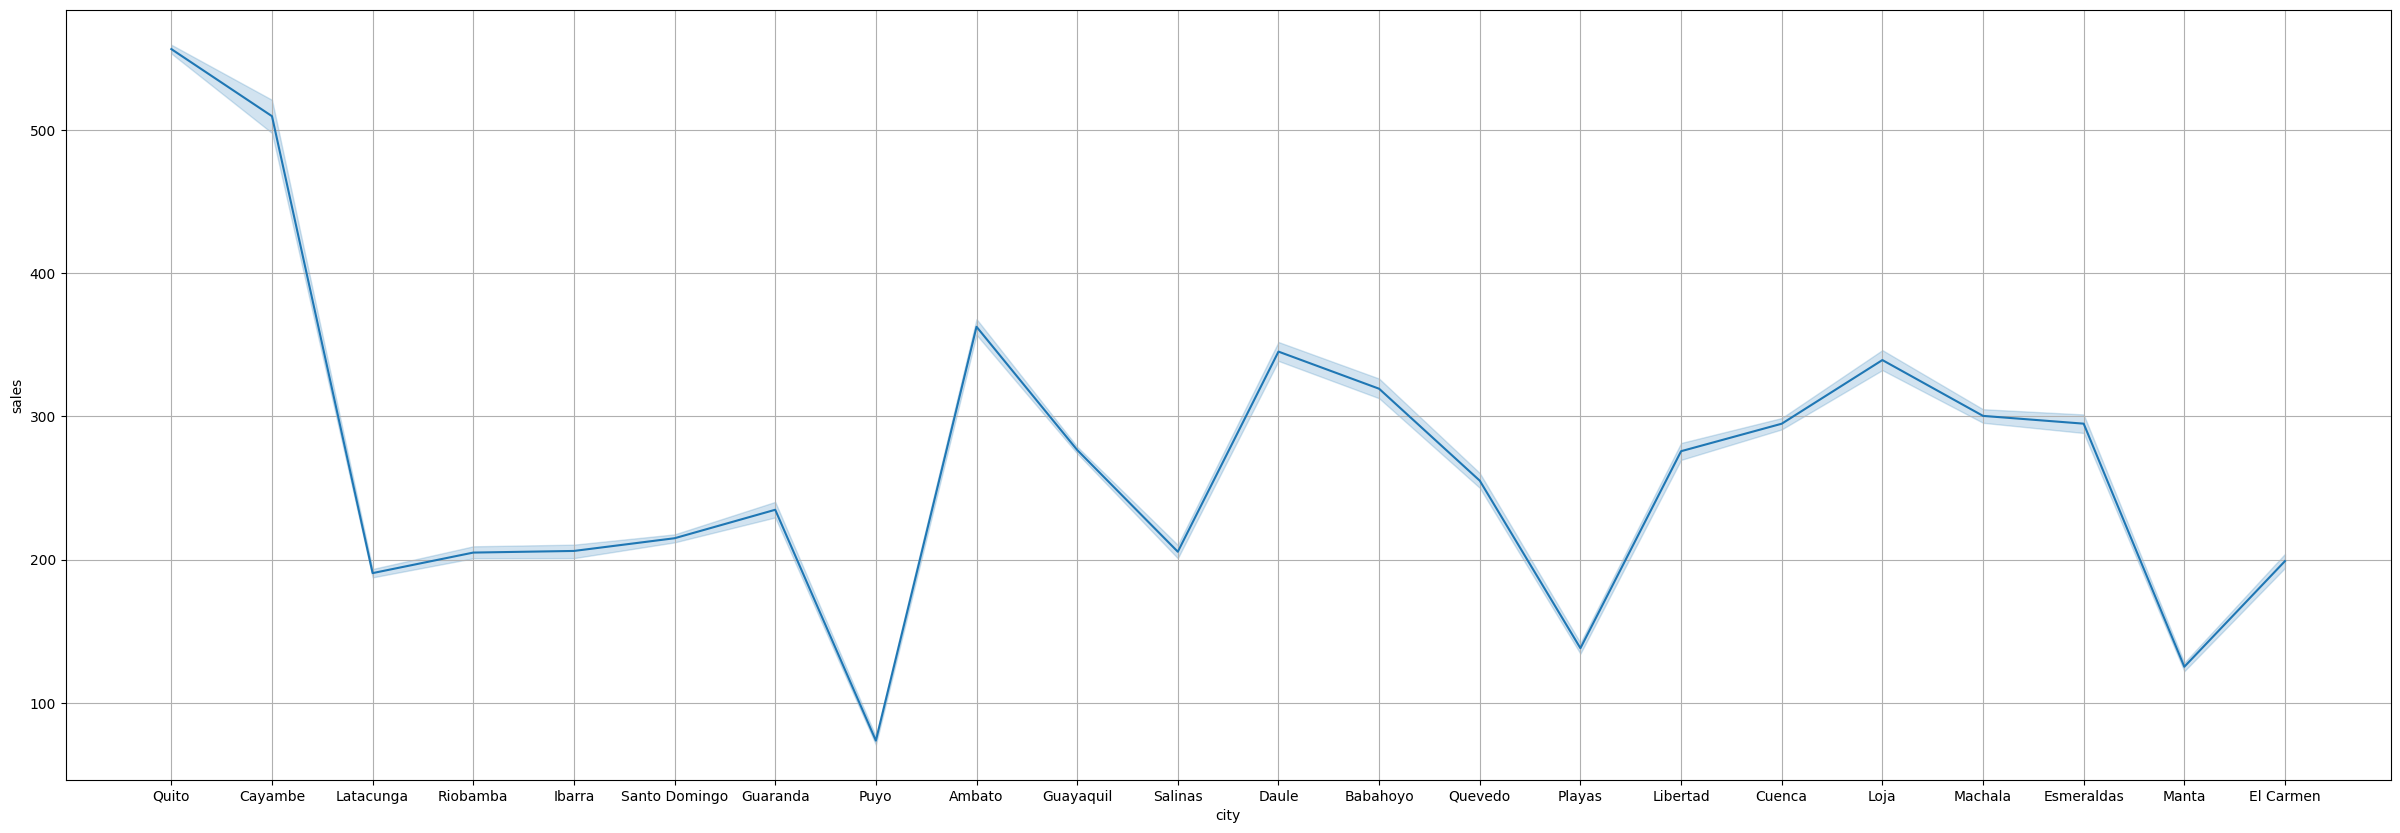

In [42]:
draw_numeric_features(raw_df, x='city', y='sales')

In [43]:
view_avg_of_each('state').head(5)

Pichincha                         554.110358
Cotopaxi                          190.583961
Chimborazo                        204.921881
Imbabura                          206.061866
Santo Domingo de los Tsachilas    214.942315
dtype: float64

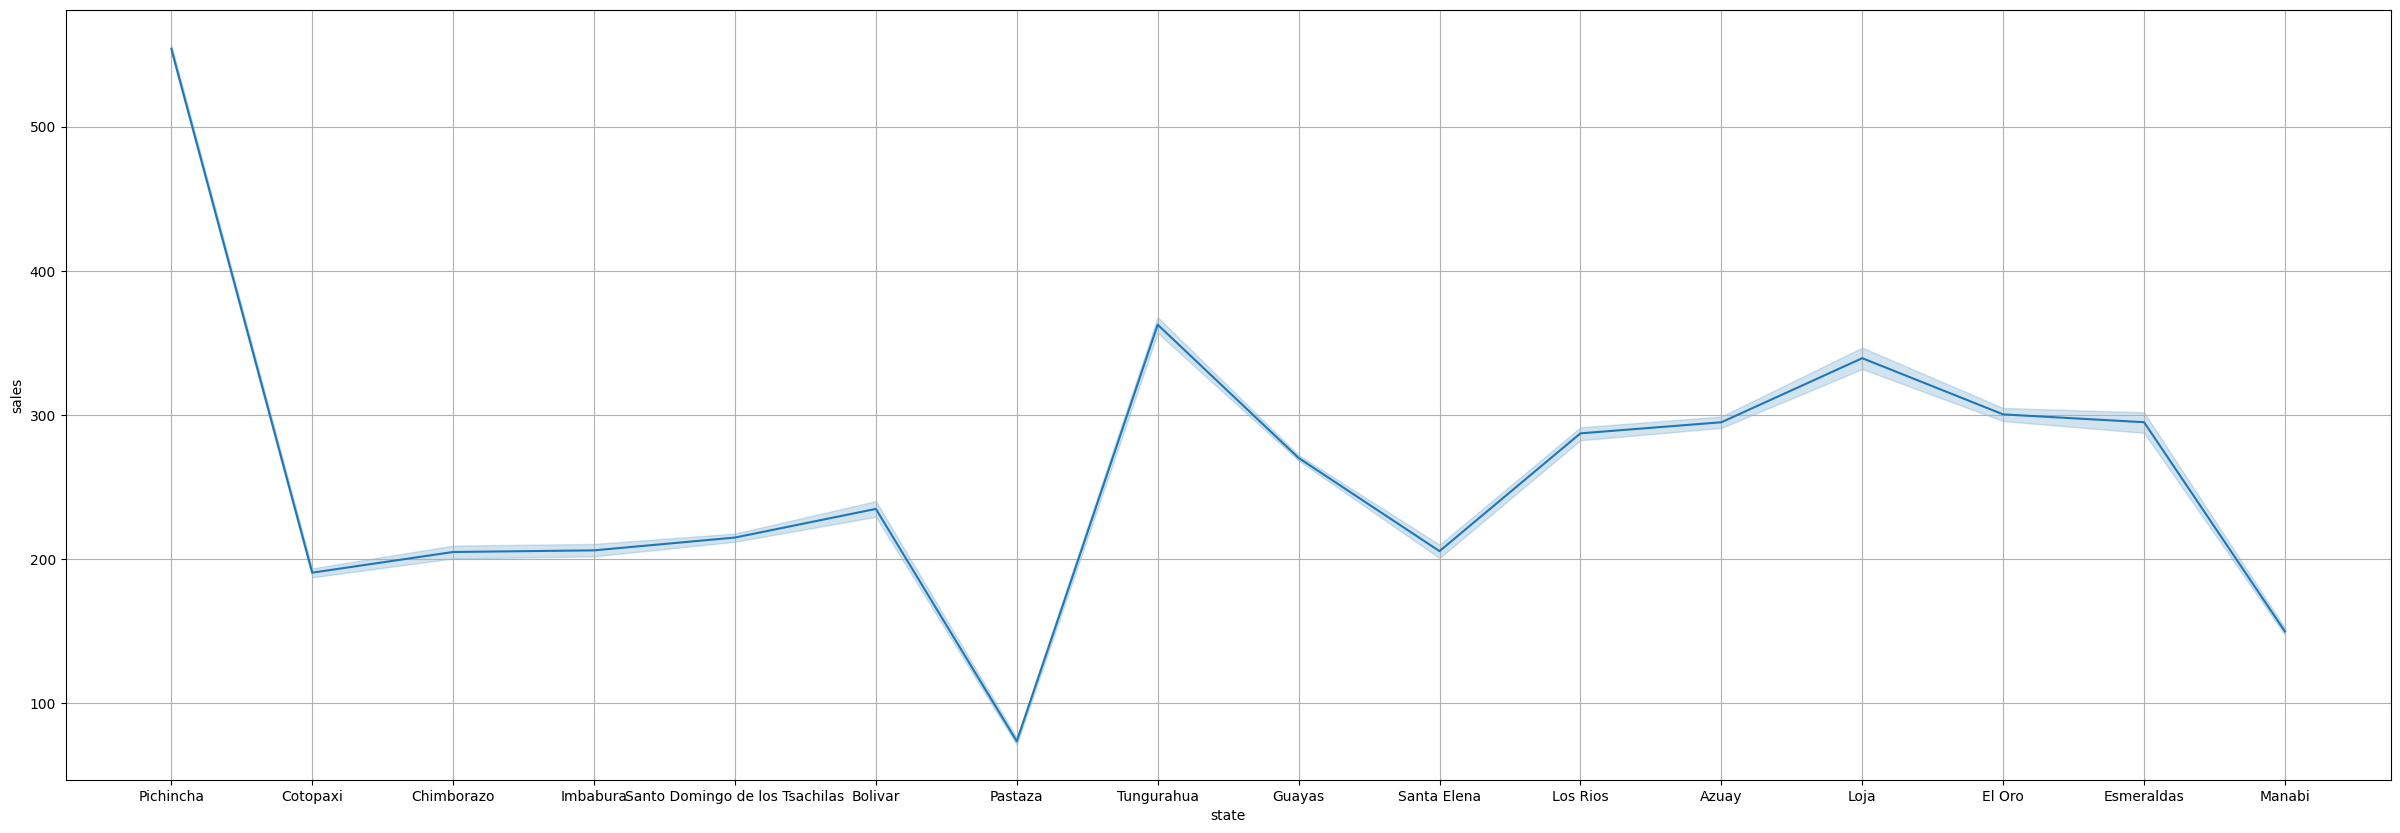

In [44]:
draw_numeric_features(raw_df, x='state', y='sales')

In [45]:
view_avg_of_each('type')

D    350.979407
C    197.263301
B    326.739714
E    269.121301
A    705.878743
dtype: float64

In [46]:
view_avg_of_each('cluster').head()

13    324.364108
15    199.010111
6     342.661732
7     139.261863
3     194.416262
dtype: float64

### transactions_df

In [47]:
transactions_df

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [48]:
get_info_of_date(transactions_df)

In [49]:
all_trans_df = transactions_df[transactions_df['date']>=training_date_min].groupby('date')['transactions'].sum().to_frame()

In [50]:
all_trans_df

,transactions
date,
2016-08-01,87637
2016-08-02,85044
2016-08-03,84532
2016-08-04,78516
2016-08-05,84616
...,...
2017-08-11,89551
2017-08-12,89927
2017-08-13,85993


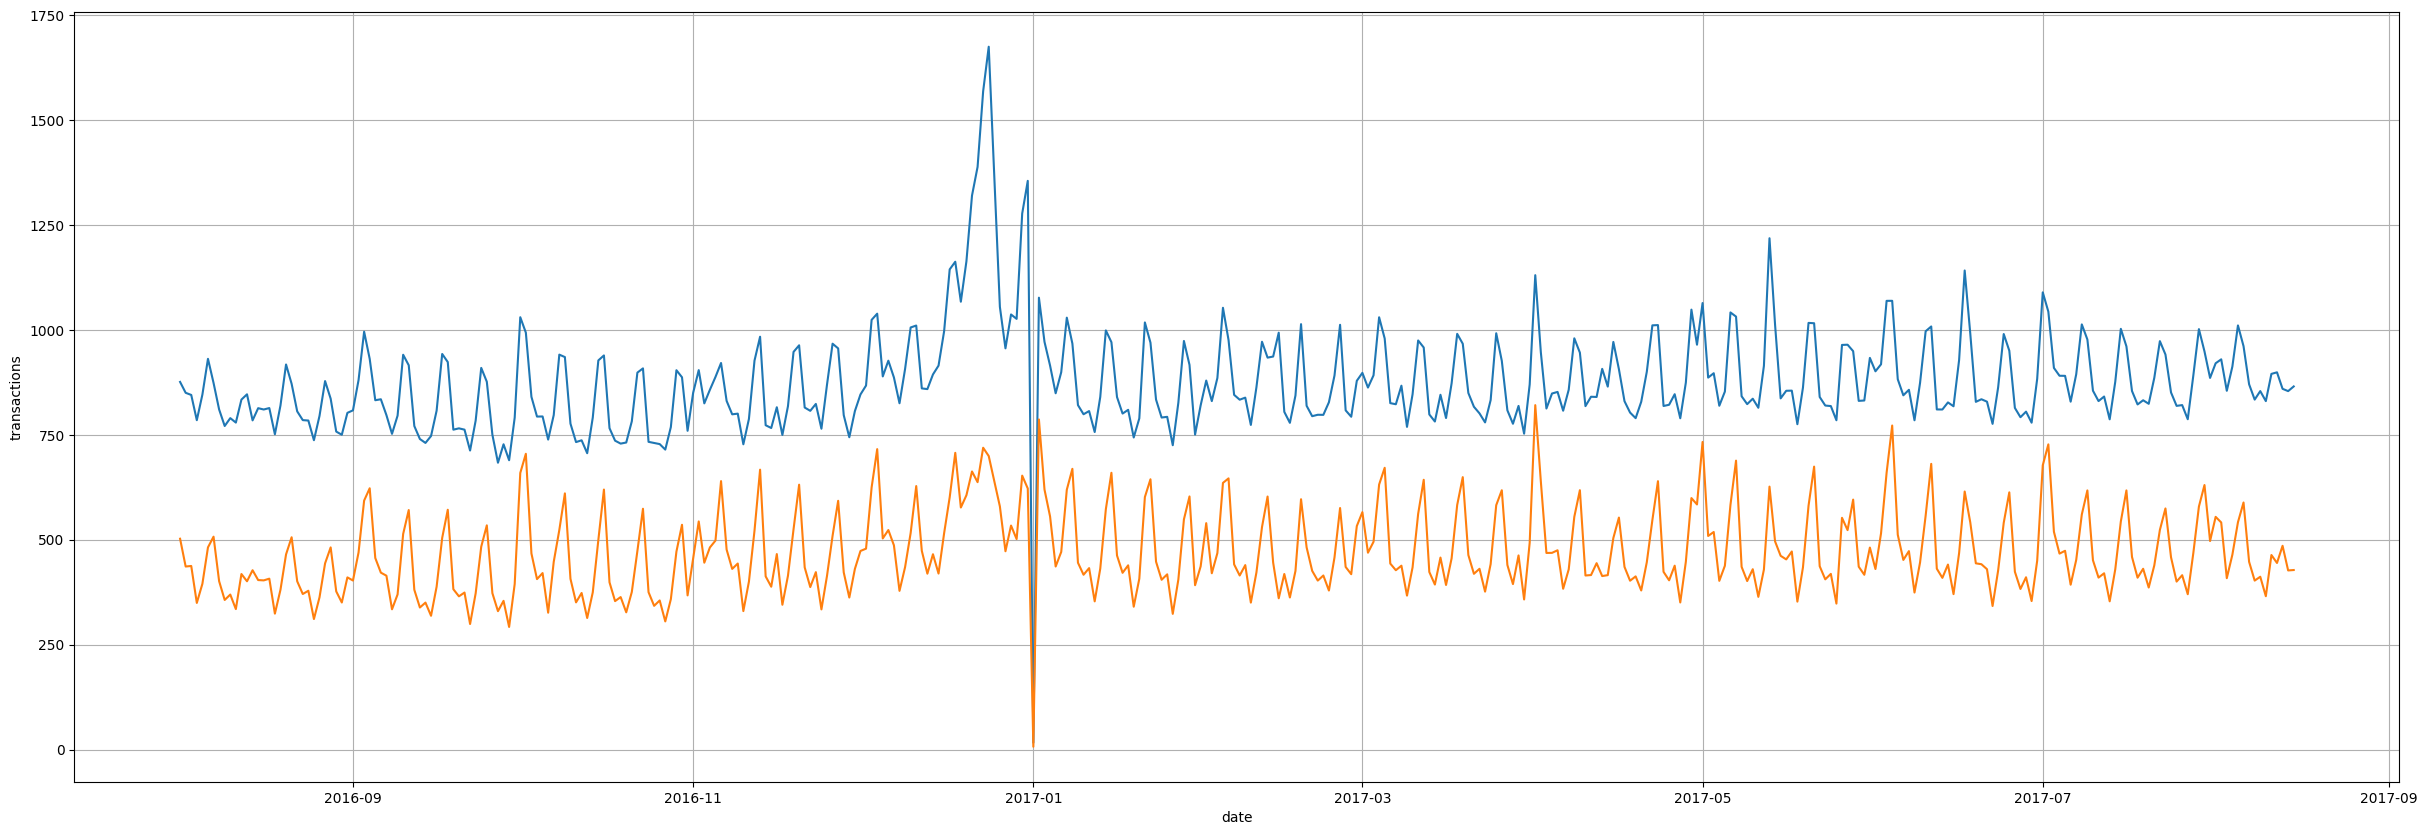

In [51]:
draw_numeric_features(all_trans_df.apply(lambda x: x/100),
                      x='date', y='transactions',
                      overlap=[[all_sales_df, 'date', 'sales']])

In [52]:
transactions_df = transactions_df[['date','store_nbr', 'transactions']]
transactions_df

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [53]:
rows_to_drop = all_trans_df[(all_trans_df.index > pd.to_datetime("2016-12-20")) & (all_trans_df.index < pd.to_datetime("2017-01-03"))]

In [54]:
rows_to_drop.index

DatetimeIndex(['2016-12-21', '2016-12-22', '2016-12-23', '2016-12-24',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31', '2017-01-01', '2017-01-02'],
              dtype='datetime64[ns]', name='date', freq=None)

In [55]:
raw_df = pd.merge(left=raw_df, right=transactions_df, on=['date','store_nbr'], how='left')
test_df = pd.merge(left=test_df, right=transactions_df, on=['date','store_nbr'], how='left')

### holidays_df

In [56]:
holidays_df

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [57]:
get_info_of_date(holidays_df)

In [58]:
holidays_df['locale'].value_counts()

locale
National    174
Local       152
Regional     24
Name: count, dtype: int64

In [59]:
national_hol_days = holidays_df[(holidays_df['locale']=='National')*(holidays_df['transferred']==False)]
national_hol_days

,date,type,locale,locale_name,description,transferred,year,month,day,day_of_week
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,2012,8,10,4
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,2012,10,12,4
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False,2012,11,2,4
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False,2012,11,3,5
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False,2012,12,21,4
...,...,...,...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,2017,12,22,4
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,2017,12,23,5
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,2017,12,24,6
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,2017,12,25,0


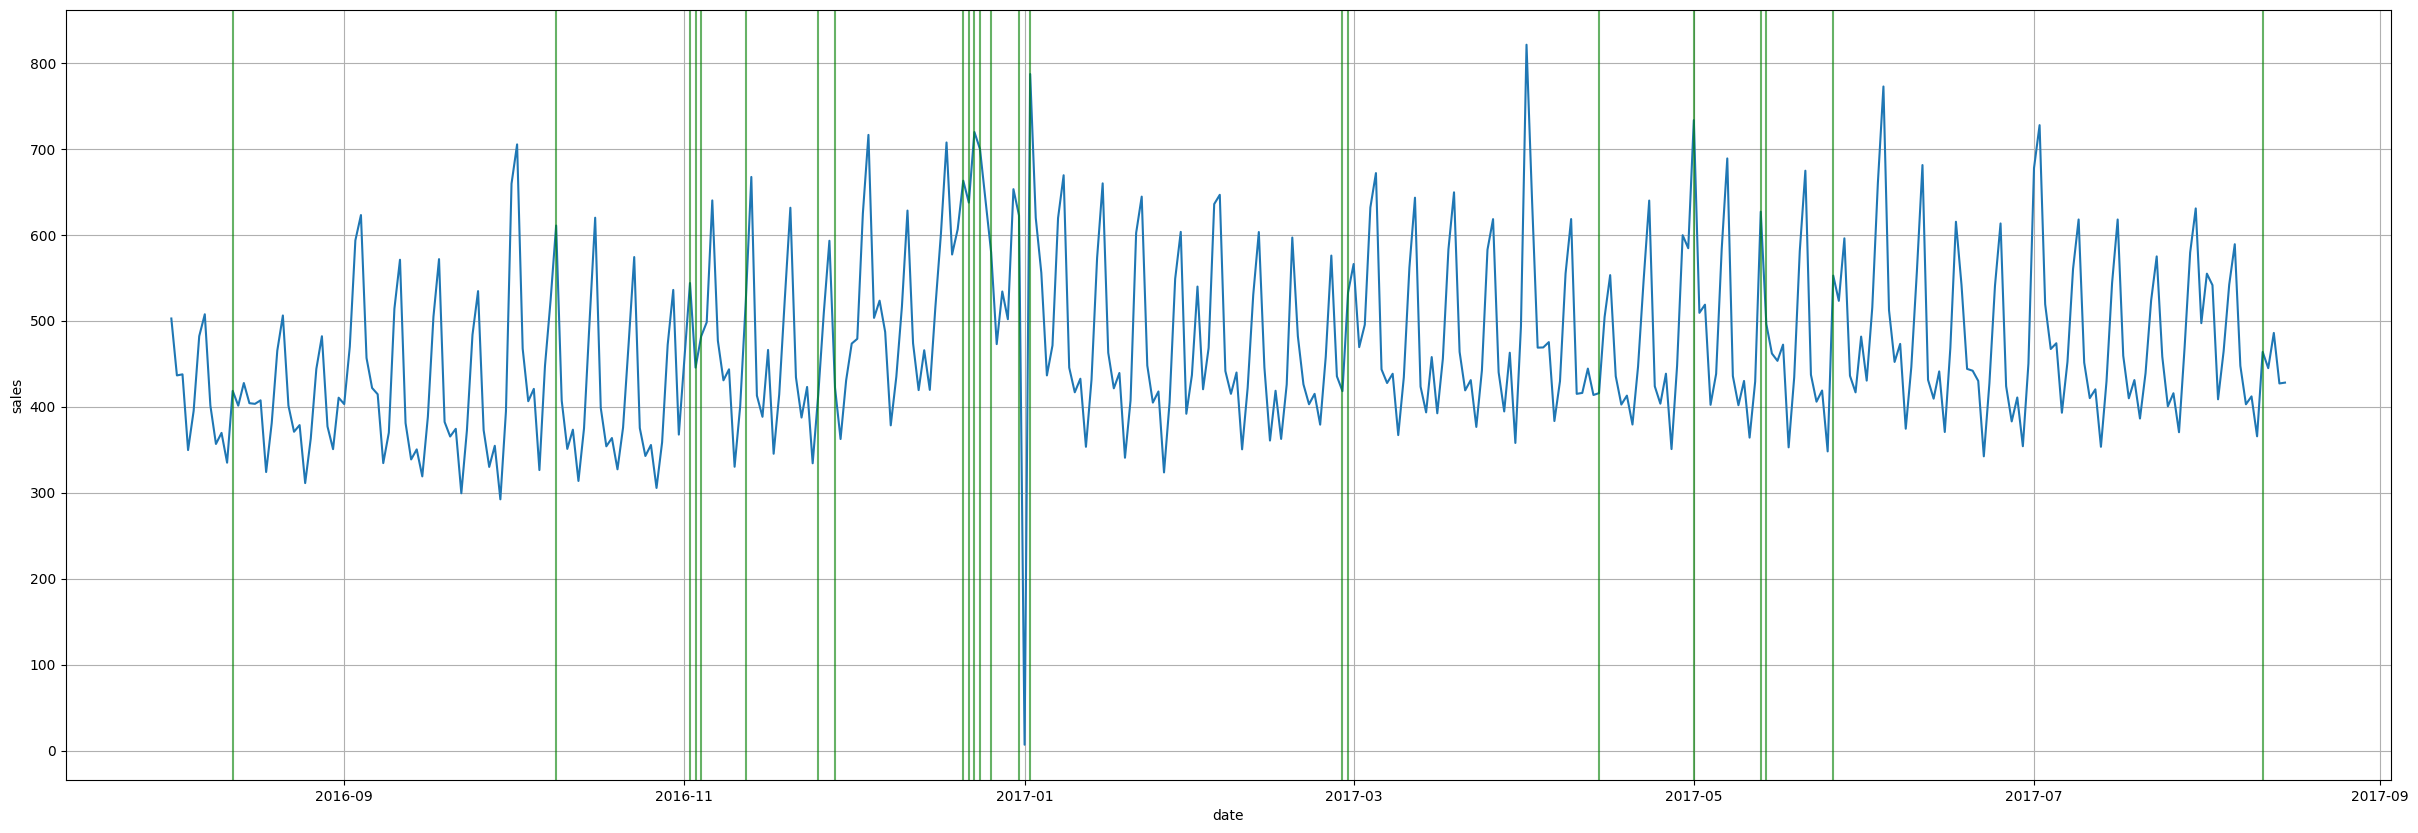

In [60]:
draw_numeric_features(all_sales_df, 'date', 'sales')
for date in all_sales_df.index:
    if date in national_hol_days['date'].values:
        plt.axvline(date, alpha=0.6, color='g')

In [61]:
national_hol_days = national_hol_days[['date','type']]

In [62]:
national_hol_days.rename({'type': 'hol_type'}, inplace=True, axis=1)
national_hol_days['hol_type'] = national_hol_days.apply(lambda x: 'Holiday', axis=1)

C:\Users\admin\AppData\Local\Temp\ipykernel_10768\1402921922.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  national_hol_days.rename({'type': 'hol_type'}, inplace=True, axis=1)
C:\Users\admin\AppData\Local\Temp\ipykernel_10768\1402921922.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  national_hol_days['hol_type'] = national_hol_days.apply(lambda x: 'Holiday', axis=1)


In [63]:
raw_df = pd.merge(left=raw_df, right=national_hol_days, on='date', how='left')
test_df = pd.merge(left=test_df, right=national_hol_days, on='date', how='left')

### Other

In [64]:
raw_df = raw_df[raw_df['date']>=training_date_min]

In [65]:
raw_df

,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,is_weekend,dcoilwtico,month_from,city,state,type,cluster,transactions,hol_type
2332638,2016-08-01,1,AUTOMOTIVE,3.000,0,2016,8,1,0,0,40.05,44,Quito,Pichincha,D,13,1750.0,NaN
2332639,2016-08-01,1,BABY CARE,0.000,0,2016,8,1,0,0,40.05,44,Quito,Pichincha,D,13,1750.0,NaN
2332640,2016-08-01,1,BEAUTY,3.000,0,2016,8,1,0,0,40.05,44,Quito,Pichincha,D,13,1750.0,NaN
2332641,2016-08-01,1,BEVERAGES,2418.000,10,2016,8,1,0,0,40.05,44,Quito,Pichincha,D,13,1750.0,NaN
2332642,2016-08-01,1,BOOKS,0.000,0,2016,8,1,0,0,40.05,44,Quito,Pichincha,D,13,1750.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,2017-08-15,9,POULTRY,438.133,0,2017,8,15,1,0,47.57,56,Quito,Pichincha,B,6,2155.0,NaN
3008012,2017-08-15,9,PREPARED FOODS,154.553,1,2017,8,15,1,0,47.57,56,Quito,Pichincha,B,6,2155.0,NaN
3008013,2017-08-15,9,PRODUCE,2419.729,148,2017,8,15,1,0,47.57,56,Quito,Pichincha,B,6,2155.0,NaN
3008014,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2017,8,15,1,0,47.57,56,Quito,Pichincha,B,6,2155.0,NaN


In [66]:
import numpy as np

In [67]:
raw_df['date'] = raw_df['date'].apply(lambda x: np.nan if x in rows_to_drop.index else x)

In [68]:
raw_df.dropna(subset=['date'], inplace=True)

In [69]:
transactions_mean = raw_df['transactions'].mean()
raw_df.fillna({'transactions': transactions_mean}, inplace=True)

In [70]:
test_df.fillna({'transactions': transactions_mean}, inplace=True)

In [71]:
raw_df.fillna({'hol_type': 'No'}, inplace=True)
test_df.fillna({'hol_type': 'No'}, inplace=True)

In [72]:
raw_df['day_of_week_mean'] = raw_df.groupby('day_of_week')['sales'].transform('mean')
raw_df['day_of_week_mean'].value_counts()

day_of_week_mean
420.021507    96228
444.555578    94446
438.909111    92664
366.095174    92664
436.105166    92664
556.524707    92664
606.124041    92664
Name: count, dtype: int64

In [73]:
day_of_week_family_store_means = raw_df.groupby(['day_of_week','family','store_nbr'])['sales'].mean()
day_of_week_family_store_means

day_of_week  family      store_nbr
0            AUTOMOTIVE  1             3.981132
                         2             6.358491
                         3             9.113208
                         4             3.075472
                         5             5.698113
                                        ...    
6            SEAFOOD     50           27.178635
                         51           61.826058
                         52            3.809385
                         53            7.957423
                         54            2.519231
Name: sales, Length: 12474, dtype: float64

In [74]:
raw_df['day_of_week_family_store_mean'] = raw_df.apply(
    lambda x: day_of_week_family_store_means.get((x['day_of_week'],x['family'],x['store_nbr'])),
    axis=1
)

In [75]:
raw_df['sales'].corr(raw_df['day_of_week_family_store_mean'])

0.9699601444436112

In [76]:
family_store_means = raw_df.groupby(['family','store_nbr'])['sales'].mean()

In [77]:
raw_df['family_store_mean'] = raw_df.apply(
    lambda x: family_store_means.get((x['family'],x['store_nbr'])),
    axis=1
)

In [78]:
raw_df['sales'].corr(raw_df['family_store_mean'])

0.9415627071479978

In [79]:
test_df['day_of_week_family_store_mean'] = test_df.apply(
    lambda x: day_of_week_family_store_means.get((x['day_of_week'],x['family'],x['store_nbr'])),
    axis=1
)

In [80]:
test_df['family_store_mean'] = test_df.apply(
    lambda x: family_store_means.get((x['family'],x['store_nbr'])),
    axis=1
)

### Preprocessing

In [81]:
input_cols = raw_df.columns.tolist()
input_cols

['date',
 'store_nbr',
 'family',
 'sales',
 'onpromotion',
 'year',
 'month',
 'day',
 'day_of_week',
 'is_weekend',
 'dcoilwtico',
 'month_from',
 'city',
 'state',
 'type',
 'cluster',
 'transactions',
 'hol_type',
 'day_of_week_mean',
 'day_of_week_family_store_mean',
 'family_store_mean']

In [82]:
numeric_cols = ['onpromotion','dcoilwtico','transactions',
                'day_of_week_family_store_mean', 'family_store_mean',
                'year','month','day']
categorical_cols = ['day_of_week','family','store_nbr',
                    'is_weekend','city','state','type','cluster','hol_type']
len(numeric_cols + categorical_cols)

17

In [83]:
from sklearn.preprocessing import OrdinalEncoder

In [85]:
encoder = OrdinalEncoder()
encoder.fit(raw_df[categorical_cols])

OrdinalEncoder()

In [86]:
raw_df[categorical_cols] = encoder.transform(raw_df[categorical_cols])

In [87]:
raw_df[categorical_cols]

,day_of_week,family,store_nbr,is_weekend,city,state,type,cluster,hol_type
2332638,0.0,0.0,0.0,0.0,18.0,12.0,3.0,12.0,1.0
2332639,0.0,1.0,0.0,0.0,18.0,12.0,3.0,12.0,1.0
2332640,0.0,2.0,0.0,0.0,18.0,12.0,3.0,12.0,1.0
2332641,0.0,3.0,0.0,0.0,18.0,12.0,3.0,12.0,1.0
2332642,0.0,4.0,0.0,0.0,18.0,12.0,3.0,12.0,1.0
...,...,...,...,...,...,...,...,...,...
3008011,1.0,28.0,8.0,0.0,18.0,12.0,1.0,5.0,1.0
3008012,1.0,29.0,8.0,0.0,18.0,12.0,1.0,5.0,1.0
3008013,1.0,30.0,8.0,0.0,18.0,12.0,1.0,5.0,1.0
3008014,1.0,31.0,8.0,0.0,18.0,12.0,1.0,5.0,1.0


In [88]:
test_df[categorical_cols] = encoder.transform(test_df[categorical_cols])

### Split train, val and inputs, targets

In [89]:
train_df = raw_df[raw_df['date'] < pd.to_datetime('2017-08-01')].copy()
val_df = raw_df[raw_df['date'] >= pd.to_datetime('2017-08-01')].copy()
len(train_df), len(val_df)

(627264, 26730)

In [121]:
input_cols = numeric_cols + categorical_cols
train_inputs = train_df[input_cols]
val_inputs = val_df[input_cols]
test_inputs = test_df[input_cols]

In [91]:
train_targets = train_df['sales']
val_targets = val_df['sales']

## Training Model

In [93]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error

In [94]:
regressor = {
    'RF': RandomForestRegressor(n_jobs=-1),
    'XGB': XGBRegressor(n_jobs=-1),
    'LGBM': LGBMRegressor(n_jobs=-1)
}
result = {'Reg': [], 'Loss': []}

In [96]:
for reg_name, reg in regressor.items():
    reg.fit(train_inputs, train_targets)
    preds = reg.predict(val_inputs)
    preds = pd.Series(preds).apply(lambda x: 0 if x<0 else x)
    loss = np.sqrt(mean_squared_log_error(val_targets, preds))
    result['Reg'].append(reg_name)
    result['Loss'].append(loss)
result_df = pd.DataFrame(result)
result_df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 627264, number of used features: 17
[LightGBM] [Info] Start training from score 466.650170


,Reg,Loss
0,RF,0.421277
1,RF,0.422798
2,XGB,0.712687
3,LGBM,0.761701


In [101]:
def test_params(**params):
    model = XGBRegressor(**params)
    model.fit(train_inputs, train_targets)
    train_preds = model.predict(train_inputs)
    train_preds = pd.Series(train_preds).apply(lambda x: 0 if x<0 else x)
    val_preds = model.predict(val_inputs)
    val_preds = pd.Series(val_preds).apply(lambda x: 0 if x<0 else x)
    train_loss = np.sqrt(mean_squared_log_error(train_targets, train_preds))
    val_loss = np.sqrt(mean_squared_log_error(val_targets, val_preds))
    return train_loss, val_loss

In [115]:
test_params(n_jobs=-1)

(0.7720333055216644, 0.7126870054716318)

In [103]:
for i in [None,3,6,9,12,14]:
    print(test_params(n_jobs=-1, max_depth=i))

(0.7720333055216644, 0.7126870054716318)
(1.037288707915007, 0.9022062995390184)
(0.7720333055216644, 0.7126870054716318)
(0.5689644989861509, 0.5526833680871229)
(0.4645769860301407, 0.45793453689689284)
(0.4148877975280361, 0.4319787351499378)


In [104]:
for i in [70,100,150,200,250]:
    print(test_params(n_jobs=-1, max_depth=11,
                      n_estimators=i))

(0.4927252369152174, 0.4606642096929198)
(0.48481650583698616, 0.45710314961672105)
(0.4746694117339816, 0.4531148995020924)
(0.4618983805125873, 0.46182604103526237)
(0.4550584958898549, 0.45740186738409544)


In [106]:
for i in [0.05,0.1,0.15,0.2,0.3]:
    print(test_params(n_jobs=-1, max_depth=11,
                      n_estimators=150, learning_rate=i))

(0.5146383731090818, 0.45312723268516464)
(0.48586330788184634, 0.4406262952151649)
(0.4811010875886245, 0.4435015226436253)
(0.48384492825326564, 0.4562372845389505)
(0.4746694117339816, 0.4531148995020924)


In [116]:
model = XGBRegressor(n_jobs=-1, max_depth=11,
                     n_estimators=150, learning_rate=0.1)

In [117]:
%%time
model.fit(train_inputs, train_targets)

CPU times: total: 52.2 s
Wall time: 9.83 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [118]:
model.feature_importances_

array([0.00269155, 0.00282053, 0.00954763, 0.9296171 , 0.00493299,
       0.00425842, 0.00834187, 0.00628303, 0.00561004, 0.00340761,
       0.00485863, 0.00250193, 0.00182791, 0.0024276 , 0.00501434,
       0.00585884], dtype=float32)

In [110]:
model.feature_names_in_

array(['onpromotion', 'dcoilwtico', 'transactions',
       'day_of_week_family_store_mean', 'family_store_mean', 'year',
       'month', 'day', 'day_of_week', 'family', 'store_nbr', 'is_weekend',
       'city', 'state', 'type', 'cluster', 'hol_type'], dtype='<U29')

In [119]:
val_preds = model.predict(val_inputs)
val_preds = pd.Series(val_preds).apply(lambda x: 0 if x<0 else x)
val_loss = np.sqrt(mean_squared_log_error(val_targets, val_preds))
val_loss

0.4406262952151649

In [112]:
preds = model.predict(test_inputs)
preds = pd.Series(preds).apply(lambda x: 0 if x<0 else x)
sub_df['sales'] = preds

In [113]:
sub_df.to_csv('data/sub6.csv', index=None)

In [124]:
sub_df['sales'] = sub_df['sales'].apply(lambda x: x if x>0 else 0)

In [125]:
sub_df.to_csv('data/sub5.csv', index=None)

In [122]:
def test_params(**params):
    model = LGBMRegressor(**params)
    model.fit(train_inputs, train_targets)
    train_preds = model.predict(train_inputs)
    train_preds = pd.Series(train_preds).apply(lambda x: 0 if x<0 else x)
    val_preds = model.predict(val_inputs)
    val_preds = pd.Series(val_preds).apply(lambda x: 0 if x<0 else x)
    train_loss = np.sqrt(mean_squared_log_error(train_targets, train_preds))
    val_loss = np.sqrt(mean_squared_log_error(val_targets, val_preds))
    return train_loss, val_loss

In [123]:
losses = []
for i in ['gbdt','dart']:
    losses.append(
        test_params(n_jobs=-1, boosting_type=i)
    )
print(losses)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 627264, number of used features: 17
[LightGBM] [Info] Start training from score 466.650170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 627264, number of used features: 17
[LightGBM] [Info] Start training from score 466.650170
[(0.8637071346747638, 0.7617012934889086), (1.0453010461413608, 0.9113964820965675)]


In [126]:
losses = []
for i in range(120,150,7):
    losses.append(
        test_params(n_jobs=-1, num_leaves=i)
    )
for loss in losses:
    print(loss)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 627264, number of used features: 17
[LightGBM] [Info] Start training from score 466.650170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 627264, number of used features: 17
[LightGBM] [Info] Start training from score 466.650170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

In [128]:
losses = []
for i in [0.03,0.05,0.1,0.15,0.2,0.3]:
    losses.append(
        test_params(n_jobs=-1, num_leaves=127,
                    learning_rate=i)
    )
for loss in losses:
    print(loss)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 627264, number of used features: 17
[LightGBM] [Info] Start training from score 466.650170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 627264, number of used features: 17
[LightGBM] [Info] Start training from score 466.650170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

In [129]:
losses = []
for i in [70,100,150,200,250,300]:
    losses.append(
        test_params(n_jobs=-1, num_leaves=127,
                    learning_rate=0.15, n_estimators=i)
    )
for loss in losses:
    print(loss)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 627264, number of used features: 17
[LightGBM] [Info] Start training from score 466.650170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 627264, number of used features: 17
[LightGBM] [Info] Start training from score 466.650170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

In [130]:
losses = []
for i in ['regression', 'tweedie']:
    losses.append(
        test_params(n_jobs=-1, num_leaves=127,
                    learning_rate=0.15, n_estimators=150,
                    objective=i)
    )
for loss in losses:
    print(loss)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 627264, number of used features: 17
[LightGBM] [Info] Start training from score 466.650170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 627264, number of used features: 17
[LightGBM] [Info] Start training from score 6.145580
(0.6379819431222047, 0.565493154250365)
(0.3858103718724276, 0.41167204191266465)


In [131]:
losses = []
for i in [0.3,0.5,0.7,0.9,1]:
    losses.append(
        test_params(n_jobs=-1, num_leaves=127,
                    learning_rate=0.15, n_estimators=150,
                    objective='tweedie', subsample=i)
    )
for loss in losses:
    print(loss)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 627264, number of used features: 17
[LightGBM] [Info] Start training from score 6.145580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 627264, number of used features: 17
[LightGBM] [Info] Start training from score 6.145580
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

In [133]:
losses = []
for i in [0,0.25,0.5,0.75,1,1.25,1.5]:
    losses.append(
        test_params(n_jobs=-1, num_leaves=127,
                    learning_rate=0.15, n_estimators=150,
                    objective='tweedie', subsample=0.7,
                    reg_alpha=i)
    )
for loss in losses:
    print(loss)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 627264, number of used features: 17
[LightGBM] [Info] Start training from score 6.145580
(0.38405845652974674, 0.4082634726706231)


In [146]:
model = LGBMRegressor(learning_rate=0.055,
                      objective='tweedie')

In [147]:
%%time
model.fit(train_inputs, train_targets)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 627264, number of used features: 17
[LightGBM] [Info] Start training from score 6.145580
CPU times: total: 8.14 s
Wall time: 4.92 s


LGBMRegressor(learning_rate=0.055, objective='tweedie')

In [148]:
val_preds = model.predict(val_inputs)
val_preds = pd.Series(val_preds).apply(lambda x: 0 if x<0 else x)
val_loss = np.sqrt(mean_squared_log_error(val_targets, val_preds))
val_loss

0.4427539864898401

In [149]:
preds = model.predict(test_inputs)
preds = pd.Series(preds).apply(lambda x: 0 if x<0 else x)
sub_df['sales'] = preds

In [150]:
sub_df.to_csv('data/sub9.csv', index=None)

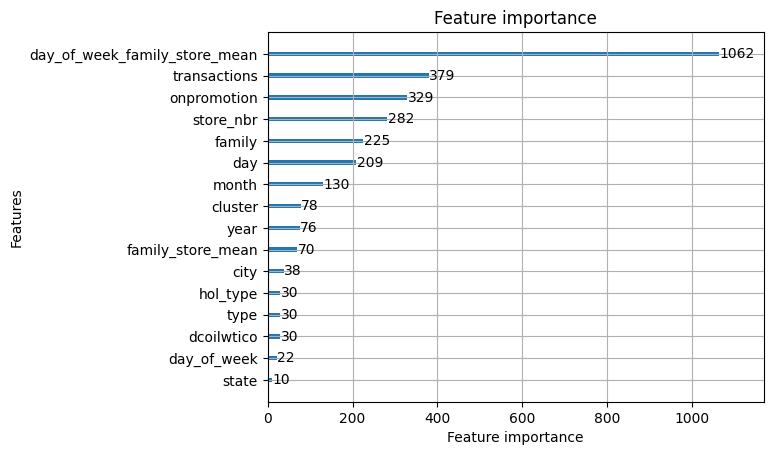

<Figure size 3000x1200 with 0 Axes>

In [151]:
from lightgbm import plot_importance
plot_importance(model)
plt.figure(figsize=(30,12));